In [1]:
import os
import math
import random 
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from Util_def import *
from Util_model import *
from pypfopt import (
    EfficientFrontier,
    risk_models,
    expected_returns,
    objective_functions,
)

import warnings
warnings.filterwarnings('ignore')


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [2]:
dow30_list = pd.read_csv('dow30_list.csv')
dow30_list = dow30_list['SYMBOL'].tolist()

# 5 years data
startDate = dt.datetime(2010, 1, 1)
endDate = dt.datetime(2025, 7, 28)

start_rebalance_year = 2016  # startDate.year + 3

data = getData(dow30_list, startDate, endDate)
data.fillna(method='ffill', inplace=True)
# data.fillna(method='bfill', inplace=True)
print(data.info())
avg_days = avg_days_per_month(data)

print("=" * 50)
print("Min Date:", data.index.min())
print("Max Date:", data.index.max())
print("Start Rebalance Year:", start_rebalance_year)
print(f"Average number of trading days per month: {avg_days}", "days")
print("=" * 50)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  30 of 30 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3914 entries, 2010-01-04 to 2025-07-25
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    3914 non-null   float64
 1   AMGN    3914 non-null   float64
 2   AMZN    3914 non-null   float64
 3   AXP     3914 non-null   float64
 4   BA      3914 non-null   float64
 5   CAT     3914 non-null   float64
 6   CRM     3914 non-null   float64
 7   CSCO    3914 non-null   float64
 8   CVX     3914 non-null   float64
 9   DIS     3914 non-null   float64
 10  GS      3914 non-null   float64
 11  HD      3914 non-null   float64
 12  HON     3914 non-null   float64
 13  IBM     3914 non-null   float64
 14  JNJ     3914 non-null   float64
 15  JPM     3914 non-null   float64
 16  KO      3914 non-null   float64
 17  MCD     3914 non-null   float64
 18  MMM     3914 non-null   float64
 19  MRK     3914 non-null   float64
 20  MSFT    3914 non-null   float64
 21  NKE     3914 non-nu

In [3]:
###### Portfolio Type ######
long_only = tuple([0,1])
long_short = tuple([-1,1])

port_type = long_only 

# Training

In [4]:
# Directory to save the results
output_dir = 'Results_NoCons'
model_type = 'Transformer'  # 'Transformer' or 'LSTM'
pe_type = 'tAPE'          
# 'OriPE', 'Time2Vec', 
# 'ConvSPE', 'SineSPE', 
# 'TemporalPE', 'LearnablePE', 
# 'AbsolutePE', 'tAPE'
pre_post = 'PostNorm'       # 'PostNorm' or 'PreNorm'
n_temp = 1.0
train_type = f'01_2_{model_type}_{pe_type}_{pre_post}_temp_{n_temp}'  # '01_1', '01_2', '01_3', etc.
run_no = '2_Return'

# --- เริ่มโค้ดสำหรับบันทึก Excel ---
results_excel_path = f"{output_dir}/{train_type}/01_Results_{model_type}_{pe_type}_{pre_post}_run_{run_no}.xlsx"


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, LayerNormalization, MultiHeadAttention, Embedding, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from dateutil.parser import parse
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model as KModel, Sequential
from tensorflow.keras import layers, Model as KModel
import cvxpy as cp
import cvxopt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Layer


devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)
warnings.filterwarnings('ignore')


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


# Model

In [6]:
class Model:
    def __init__(self, max_weight=1, asset_map=None, asset_lower=None, asset_upper=None, port_type=None):
        self.data = None
        self.model = None
        self.max_weight = max_weight
        self.asset_map = asset_map or {}
        self.asset_lower = asset_lower or {}
        self.asset_upper = asset_upper or {}
        self.port_type = port_type
        self.asset_columns = None

    def _create_constraint_matrices(self, columns):
        """Create constraint matrices for asset‐type bounds."""
        self.asset_columns = columns
        
        asset_types = {}
        for asset in columns:
            t = self.asset_map.get(asset, "Unknown")
            asset_types.setdefault(t, []).append(asset)
        
        mats = []
        lbs = []
        ubs = []
        names = []
        for t, assets in asset_types.items():
            vec = np.zeros(len(columns), dtype=float)
            for a in assets:
                idx = columns.get_loc(a)
                vec[idx] = 1.0
            mats.append(vec)
            lbs.append(self.asset_lower.get(t, 0.0))
            ubs.append(self.asset_upper.get(t, 1.0))
            names.append(t)
        
        self.constraint_matrix = np.vstack(mats)        # shape = (n_types, n_assets)
        self.lower_bounds = np.array(lbs, dtype=float)  # shape = (n_types,)
        self.upper_bounds = np.array(ubs, dtype=float)  # shape = (n_types,)
        self.asset_type_names = names
        
    # Final New QP with two phases - this allows for hard constraints on zero weights
    def _apply_constraints_final(self, weights):
        """
        ใช้ Quadratic Programming เพื่อบังคับ:
        • Σw = 1
        • per-asset cap 0.30 (SHV 0.40)
        • asset_lower / asset_upper
        • ลดการขยับจาก w0 โดยเฉพาะตำแหน่งที่ w0 == 0
        """
        w0 = np.asarray(weights, float).copy()
        n  = w0.size

        # ---------- สร้างขอบรายตัว --------------------------------------------
        ub = np.full(n, 0.30)
        # if self.asset_columns is not None and "SHV" in self.asset_columns:
        #     ub[self.asset_columns.get_loc("SHV")] = 0.40

        lb = np.full(n, self.port_type[0])      # long_only → 0, long/short → -1
        # (ถ้ามีพอร์ตชนิดอื่นปรับได้ตาม self.port_type)

        # ---------- ตัวแปร QP ---------------------------------------------------
        w = cp.Variable(n)

        constraints = [
            cp.sum(w) == 1,
            w >= lb,
            w <= ub
        ]

        # # ---------- ข้อจำกัดรายหมวด -------------------------------------------
        # if hasattr(self, "constraint_matrix"):
        #     C = self.constraint_matrix           # shape (n_types, n_assets)
        #     constraints += [
        #         C @ w >= self.lower_bounds,
        #         C @ w <= self.upper_bounds
        #     ]

        # ---------- Objective: min Σ α_i (w_i - w0_i)^2 ------------------------
        eps = 1e-4
        alpha = 1.0 / (w0 + eps)        # ช่องที่ w0=0 จะถูกลงโทษมาก
        #obj   = cp.Minimize(cp.sum(cp.multiply(alpha, cp.square(w - w0)))) # L2
        obj = cp.Minimize(cp.sum(cp.multiply(alpha, cp.abs(w - w0)))) # L1

        prob = cp.Problem(obj, constraints)

        # เลือก solver ที่รองรับ QP
        try:
            prob.solve(solver=cp.OSQP)  # หรือ ECOS_BB / SCS
        except cp.error.SolverError:
            prob.solve(solver=cp.ECOS)

        # ถ้าแก้ไม่ได้ (infeasible) กลับไปใช้วิธีเดิม
        if w.value is None:
            print("QP infeasible, falling back to greedy method.")
            return super()._apply_constraints(weights)

        return np.asarray(w.value).flatten()
    # ===== END V.2 =====
    
    # _apply_constraints_row_cvxpy
    def _apply_constraints_row_cvxpy(self, weights_row, tol_zero=1e-6, lambda_zero=100.0):
        """
        Applies two-phase QP constraints to a single row of weights.
        - Phase 1: Attempts to solve with a hard lock on zero-weight assets.
        - Phase 2: If Phase 1 is infeasible, it releases the lock and instead
                   applies a heavy penalty for moving away from zero.
        """
        # ---------- Data Preparation for a single row ----------
        w0 = np.clip(weights_row, *self.port_type)
        n = len(w0)
        lower_w, _ = self.port_type

        # Upper bound vector (0.30, except 0.40 for SHV)
        ub_vec = np.full(n, 0.30)
        if 'SHV' in self.asset_columns:
            shv_idx = self.asset_columns.get_loc('SHV')
            ub_vec[shv_idx] = 0.40

        # Indices of assets with near-zero initial weights
        zero_idx = np.where(w0 <= tol_zero)[0]

        # ---------- Phase 1: Solve QP with locked zeros ----------
        w_p1 = cp.Variable(n)
        
        # Base constraints + hard lock on zeros
        cons_p1 = [w_p1 >= lower_w, w_p1 <= ub_vec]
        if len(zero_idx) > 0:
            cons_p1.append(w_p1[zero_idx] == 0)

        # Add sum-to-one and group constraints
        if self.port_type == long_only:
            cons_p1.append(cp.sum(w_p1) == 1)
        if hasattr(self, 'constraint_matrix'):
            cm, lb, ub = self.constraint_matrix, self.lower_bounds, self.upper_bounds
            cons_p1.extend([cm @ w_p1 >= lb, cm @ w_p1 <= ub])
        
        obj_p1 = cp.Minimize(cp.sum_squares(w_p1 - w0))
        prob_p1 = cp.Problem(obj_p1, cons_p1)
        prob_p1.solve(solver=cp.OSQP, warm_start=True)

        if prob_p1.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            return np.array(w_p1.value).flatten()

        # ---------- Phase 2: Solve QP with penalty if Phase 1 failed ----------
        print("⚠️ Strict (zero-locked) QP failed. Falling back to penalty-based QP.")
        w_p2 = cp.Variable(n)
        
        # Base constraints without the hard lock
        cons_p2 = [w_p2 >= lower_w, w_p2 <= ub_vec]
        if self.port_type == long_only:
            cons_p2.append(cp.sum(w_p2) == 1)
        if hasattr(self, 'constraint_matrix'):
            cm, lb, ub = self.constraint_matrix, self.lower_bounds, self.upper_bounds
            cons_p2.extend([cm @ w_p2 >= lb, cm @ w_p2 <= ub])
            
        # Softer objective with penalty for moving zero-weight assets
        penalty = np.ones(n)
        penalty[zero_idx] = lambda_zero
        sqrt_p = np.sqrt(penalty)
        obj_p2 = cp.Minimize(cp.sum_squares(cp.multiply(sqrt_p, w_p2 - w0)))
        
        prob_p2 = cp.Problem(obj_p2, cons_p2)
        prob_p2.solve(solver=cp.OSQP, warm_start=True)

        if prob_p2.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            return np.array(w_p2.value).flatten()
        else:
            # Final fallback if both phases fail
            print(f"❌ Warning: Both QP attempts failed (Final status: {prob_p2.status}). Using fallback normalization.")
            s = w0.sum()
            return (w0 / s) if s > 0 else np.ones_like(w0) / n
    # ===== END =====

    def build(self, input_shape, outputs, PE_type=pe_type):

        d_model = 512
        num_heads = 8
        ff_dim = 2048
        num_layers = 6
        dropout_rate = 0.3
        spe_kernel_size = 5

        seq_len, feature_dim = input_shape

        def get_positional_encoding(length, depth):
            # Halve the depth because we will concatenate sine and cosine embeddings.
            depth = depth / 2

            # Create arrays for positions and depths.
            positions = np.arange(length)[:, np.newaxis]      # Shape: (length, 1)
            depths = np.arange(depth)[np.newaxis, :] / depth  # Shape: (1, depth)

            # Calculate the angle rates.
            angle_rates = 1 / (10000**depths)                 # Shape: (1, depth)

            # Calculate the angle radians.
            angle_rads = positions * angle_rates             # Shape: (length, depth)

            # Concatenate the sine and cosine of the angle radians to form the encoding.
            pos_encoding = np.concatenate(
                [np.sin(angle_rads), np.cos(angle_rads)],
                axis=-1) 
            # Cast the final encoding to a float32 TensorFlow tensor.
            return tf.cast(pos_encoding, dtype=tf.float32)
        
        inputs = layers.Input(shape=(seq_len, feature_dim))

        # ====== Position Encoding ======
        if PE_type == 'OriPE':
            x = layers.Dense(d_model)(inputs)
            pos_encoding = get_positional_encoding(seq_len, d_model)
            x = x + pos_encoding[tf.newaxis, :]
        elif PE_type == 'Time2Vec':
            time_embedding = Time2Vector(seq_len)(inputs)
            x = layers.Concatenate(axis=-1)([inputs, time_embedding])
            x = layers.Dense(d_model)(x)
        elif PE_type == 'ConvSPE':
            x = layers.Dense(d_model)(inputs)
            x = ConvSPE(d_model=d_model, kernel_size=spe_kernel_size)(x)
        elif PE_type == 'SineSPE':
            x = layers.Dense(d_model)(inputs)
            x = SineSPE(d_model=d_model, max_len=seq_len + 100)(x)
        elif PE_type == 'TemporalPE':
            x = layers.Dense(d_model)(inputs)
            x = TemporalPositionalEncoding(d_model=d_model, max_len=seq_len + 100)(x)
        elif PE_type == 'LearnablePE':
            x = layers.Dense(d_model)(inputs)
            pos_encoding_layer = LearnablePositionalEncoding(d_model=d_model, max_len=seq_len + 100, dropout=dropout_rate)
            x = pos_encoding_layer(x)
        elif PE_type == 'AbsolutePE':
            x = layers.Dense(d_model)(inputs)
            pos_encoding_layer = AbsolutePositionalEncoding(d_model=d_model, max_len=seq_len + 100, dropout=dropout_rate)
            x = pos_encoding_layer(x)
        elif PE_type == 'tAPE':
            x = layers.Dense(d_model)(inputs)
            pos_encoding_layer = tAPE(d_model=d_model, max_len=seq_len + 100, dropout=dropout_rate)
            x = pos_encoding_layer(x)
        else:
            raise ValueError(f"Unknown Positional Encoding type: {PE_type}")

        for _ in range(num_layers):
            attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
            attn_output = layers.Dropout(dropout_rate)(attn_output)
            out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

            ffn = layers.Dense(ff_dim, activation="relu")(out1) # ori = relu
            ffn = layers.Dense(d_model)(ffn)
            ffn_output = layers.Dropout(dropout_rate)(ffn)
            x = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

        pooled = layers.GlobalAveragePooling1D()(x)       # (batch_size, d_model)
        # outputs_layer = layers.Dense(outputs, activation="softmax")(pooled)
        
        # use TemperatureSoftmax for softmax with temperature scaling
        outputs_layer = layers.Dense(outputs)(pooled)
        outputs_layer = TemperatureSoftmax(temperature=n_temp)(outputs_layer) 
          
        # outputs_layer = layers.Dense(outputs, activation=TemperatureSoftmax(3.0))(pooled)  

        model = KModel(inputs=inputs, outputs=outputs_layer)
                     
        # # Modify Sharpe loss function
        # def sharpe_loss(_, weights):
        #     w = weights[0]
        #     # 1. คำนวณอนุกรมเวลาผลตอบแทนรายวันของพอร์ต
        #     portfolio_returns_daily = tf.reduce_sum(tf.multiply(self.data, w), axis=1)
        #     # 2. คำนวณค่าสถิติรายวัน
        #     mean_daily_return = tf.reduce_mean(portfolio_returns_daily)
        #     std_daily_return = tf.math.reduce_std(portfolio_returns_daily)
        #     # 3. แปลงเป็นค่ารายปี (Annualize)
        #     annualized_return = mean_daily_return * 252
        #     annualized_volatility = std_daily_return * tf.sqrt(252.0) # ต้อง sqrt() จำนวนวัน
        #     # 4. คำนวณ Sharpe Ratio ด้วยหน่วยเวลาที่สอดคล้องกัน
        #     risk_free_rate = 0.02
        #     sharpe = (annualized_return - risk_free_rate) / (annualized_volatility + 1e-8) # เพิ่ม epsilon เพื่อความเสถียร
        #     return -sharpe
        # optimizer = tf.keras.optimizers.Adam()
        # model.compile(loss=sharpe_loss, optimizer=optimizer)
        
        # def sortino_loss(_, weights):
        #     w = weights[0]
        #     # 1. คำนวณอนุกรมเวลาผลตอบแทนรายวันของพอร์ต (Calculate daily portfolio returns time series)
        #     portfolio_returns_daily = tf.reduce_sum(tf.multiply(self.data, w), axis=1)

        #     # 2. กำหนดอัตราผลตอบแทนที่ปราศจากความเสี่ยง (Define risk-free rate)
        #     risk_free_rate_annual = 0.02
        #     # แปลงเป็นรายวันเพื่อใช้เป็น target return (Convert to daily for target return)
        #     daily_target_return = risk_free_rate_annual / 252.0

        #     # 3. คำนวณผลตอบแทนเฉลี่ยและแปลงเป็นรายปี (Calculate mean return and annualize)
        #     mean_daily_return = tf.reduce_mean(portfolio_returns_daily)
        #     annualized_return = mean_daily_return * 252.0

        #     # 4. คำนวณ Downside Deviation
        #     # 4.1 หาเฉพาะผลตอบแทนที่ต่ำกว่าเป้าหมาย (Find only returns below the target)
        #     downside_returns = tf.minimum(0.0, portfolio_returns_daily - daily_target_return)
            
        #     # 4.2 คำนวณ Downside Deviation รายวัน (Calculate daily Downside Deviation)
        #     # คือรากที่สองของค่าเฉลี่ยของผลตอบแทนที่ต่ำกว่าเป้าหมายยกกำลังสอง
        #     # (It's the square root of the mean of squared returns below the target)
        #     squared_downside_returns = tf.square(downside_returns)
        #     mean_squared_downside = tf.reduce_mean(squared_downside_returns)
        #     downside_deviation_daily = tf.sqrt(mean_squared_downside)

        #     # 4.3 แปลงเป็นรายปี (Annualize)
        #     annualized_downside_deviation = downside_deviation_daily * tf.sqrt(252.0)

        #     # 5. คำนวณ Sortino Ratio
        #     sortino = (annualized_return - risk_free_rate_annual) / (annualized_downside_deviation + 1e-8) # เพิ่ม epsilon เพื่อความเสถียร

        #     # เราต้องการ maximize Sortino Ratio ดังนั้น loss function คือค่าลบของมัน
        #     # (We want to maximize the Sortino Ratio, so the loss function is its negative)
        #     return -sortino
        # optimizer = tf.keras.optimizers.Adam()
        # model.compile(loss=sortino_loss, optimizer=optimizer)


        def maximize_return_loss(_, weights):
            w = weights[0]
            # 1. คำนวณอนุกรมเวลาผลตอบแทนรายวันของพอร์ต (Calculate daily portfolio returns time series)
            portfolio_returns_daily = tf.reduce_sum(tf.multiply(self.data, w), axis=1)

            # 2. คำนวณผลตอบแทนเฉลี่ยรายวัน (Calculate mean daily return)
            mean_daily_return = tf.reduce_mean(portfolio_returns_daily)

            # 3. แปลงเป็นผลตอบแทนรายปี (Annualize return)
            annualized_return = mean_daily_return * 252.0

            # 4. เราต้องการ maximize return ดังนั้น loss function คือค่าลบของมัน
            # (We want to maximize the return, so the loss function is its negative)
            return -annualized_return
        optimizer = tf.keras.optimizers.Adam()
        model.compile(loss=maximize_return_loss, optimizer=optimizer)
        
        return model

    def calc_wgts(self, lkbk: int, ep: int, data: pd.DataFrame, features: pd.DataFrame, patience=10, PE_type=pe_type):
        # Ensure constraint matrices exist
        if not hasattr(self, "constraint_matrix"):
            self._create_constraint_matrices(data.columns)
        
        print(f"=== Calculating weights with lkbk={lkbk}, ep={ep}, patience={patience}, PE_type={PE_type} ===")

        # Scale the features
        features = [features.shift(k).fillna(0).values[lkbk:] for k in range(lkbk)]
        
        # Create Numpy array from features
        data_array = np.concatenate(features, axis=1)
                    
        # Split off train set
        data = data.iloc[lkbk:]
        
        # Convert data to tensorflow format for processing in loss function
        self.data = tf.cast(tf.constant(data), float)

        # Building a new model (create fresh model for each rebalance)
        self.model = self.build(data_array.shape, len(data.columns), PE_type=PE_type)
        
        early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

        # Adding a new axis to features
        fit_predict_data = data_array[np.newaxis, :]

        # Adding new axis to classifier
        """Extending the length of the output vector"""
        y = np.zeros(len(data.columns))[np.newaxis, :]

        print(f"X shape: {fit_predict_data.shape}")
        # print("X:", fit_predict_data)
        print("y shape:", ep)
        # print("y:", y)
        # Fit the model  
        self.model.fit(fit_predict_data, y, epochs=ep, shuffle=False, callbacks=[early_stopping])

        # Predict weights
        raw_weights = self.model.predict(fit_predict_data)[0]
        raw_weights_non_zero_count = np.count_nonzero(raw_weights)
        print(f"Raw Weights selected ETF: {raw_weights_non_zero_count}")
        # Apply constraints
        weights = self._apply_constraints_final(raw_weights)
        return weights, raw_weights

In [7]:
# asset_weights = model.calc_wgts(lookback, n_epochs, train_features, train_features, patience=10)
def quarterly_walk_forward(df, lookback, n_epochs, features, asset_map=None, 
                                   asset_lower=None, asset_upper=None, port_type=(0, 1), 
                                   start_year=2020, trading_days_per_quarter=63, 
                                   min_train_periods=252, PE_type=pe_type, n_patience=10):
    """Optimized quarterly walk-forward analysis"""
    
    # Efficient data preparation
    original_index = df.index
    df_reset = df.reset_index(drop=True)
    features_reset = features.reset_index(drop=True)
    
    # Get rebalance dates
    rebalance_dates = get_rebalance_dates(df, start_year)
    
    # Pre-allocate result containers
    all_rets = []
    weights_list = []
    raw_weights_list = []
    rebalance_info = []
    
    # Initialize model once
    model = Model(
        max_weight=1, 
        asset_map=asset_map, 
        asset_lower=asset_lower,
        asset_upper=asset_upper, 
        port_type=port_type
    )
    
    print(f"\n=== Starting Optimized Quarterly Rebalancing Analysis ===")
    print(f"Training lookback period: {lookback} days")
    print(f"Minimum training periods: {min_train_periods} days")
    print(f"Trading days per quarter: {trading_days_per_quarter} days")
    print(f"Total rebalance periods: {len(rebalance_dates)}")
    
    for i, rebalance_date in enumerate(rebalance_dates):
        print(f"\n--- Rebalancing {i+1}/{len(rebalance_dates)} ---")
        print(f"Rebalance Date: {rebalance_date.strftime('%Y-%m-%d')}")
        
        try:
            # More efficient position finding
            train_end_pos = original_index.get_indexer([rebalance_date], method='pad')[0] - 1
            if train_end_pos < 0:
                continue
                
        except Exception:
            print(f"Cannot find position for {rebalance_date}, skipping... ❌❌❌")
            continue
        
        # Define training period
        train_start_pos = max(0, train_end_pos - min_train_periods)
        
        print(f"Training period: {original_index[train_start_pos].strftime('%Y-%m-%d')} to {original_index[train_end_pos].strftime('%Y-%m-%d')}")
        print(f"Training days: {train_end_pos - train_start_pos + 1}")
        
        # Get quarter end
        quarter_end = get_quarter_end_date(rebalance_date, original_index, trading_days_per_quarter)
        
        try:
            test_end_pos = original_index.get_loc(quarter_end)
            print(f"Test period: {rebalance_date.strftime('%Y-%m-%d')} to {quarter_end.strftime('%Y-%m-%d')}")
            print(f"Test days: {test_end_pos - train_end_pos}")
        except Exception:
            print(f"Cannot find end date for quarter, skipping... ❌❌❌")
            continue
        
        # Skip if insufficient future data
        if test_end_pos >= len(df_reset):
            print(f"Not enough future data, stopping at rebalance {i+1} ❌❌❌")
            break
        
        # Extract and prepare training data more efficiently
        train_data = df_reset.iloc[train_start_pos:train_end_pos+1].copy()
        train_features = features_reset.iloc[train_start_pos:train_end_pos+1].copy()
        
        # Efficient data cleaning
        train_data = train_data.ffill().bfill()
        train_features = train_features.fillna(0) # for cal sharpe loss (ori pct_change)
        # train_features_roll = train_features.rolling(window=5, min_periods=1).mean().fillna(0)

        # # # scale features - for training
        #sc = StandardScaler()
        #train_features_sc = train_features.copy()
        # train_features_sc = train_features_sc.rolling(window=5, min_periods=1).mean().fillna(0)
        #train_features_sc = pd.DataFrame(sc.fit_transform(train_features_sc), columns=train_features.columns, index=train_features.index)
        
        # Calculate test returns more efficiently
        test_data = df_reset.iloc[train_end_pos:test_end_pos+1].copy()
        test_returns = test_data.pct_change().fillna(0).iloc[1:]

        print(f"Training data shape: {train_data.shape}")
        print(f"Test returns shape: {test_returns.shape}")
        
        # Train model and get weights
        try:
            # Clear session for memory management
            K.clear_session()
            tf.keras.backend.clear_session()
            
            # asset_weights = model.calc_wgts(lookback, n_epochs, train_data, train_features, patience=10)
            asset_weights, raw_weights = model.calc_wgts(lookback, n_epochs, 
                                                         train_features, train_features, 
                                                         patience=n_patience, 
                                                         PE_type=PE_type)
            #asset_weights, raw_weights = model.calc_wgts(lookback, n_epochs, train_features, train_features_sc, patience=10)

            print(f"\n{'=' * 30}")
            # total weight should be 1 status
            total_weight = np.sum(asset_weights).round(4)
            if total_weight == 1:
                print(f"Total weight: {total_weight:.4f} ✅")
            else:
                print(f"Total weight: {total_weight:.4f} ❌ (should be 1.0)")
            
            weights_non_zero_count = np.count_nonzero(asset_weights)
            print(f"Selected ETF count: {weights_non_zero_count}")
            # if weights_non_zero_count < 10 or weights_non_zero_count > 15:
            #     print(f"Warning: weights have {weights_non_zero_count} ❌")
            #     os.system(f'say "Warning: Selected ETF have {weights_non_zero_count}"')
            # if weights_non_zero_count >= 10 and weights_non_zero_count <= 15:
            #     print(f"Selected ETF: {weights_non_zero_count} ✅")

            # Print allocation summary
            if hasattr(model, 'constraint_matrix') and hasattr(model, 'asset_type_names'):
                type_weights = np.dot(model.constraint_matrix, asset_weights)
                print("Asset Type Allocation:")
                for j, (asset_type, weight) in enumerate(zip(model.asset_type_names, type_weights)):
                    lower = model.asset_lower.get(asset_type, 0.0)
                    upper = model.asset_upper.get(asset_type, 1.0)
                    # status
                    if lower <= weight.round(4) <= upper:
                        status = "✅" #Within Range
                    else:
                        status = "❌" #Out of Range
                    print(f"  {asset_type}: {weight:.3f} ({weight*100:.2f}%) [Range: {lower:.2f}-{upper:.2f}] {status}")
            
            # Calculate out-of-sample returns
            if len(test_returns) > 0:
                # Vectorized return calculation
                oos_returns = (test_returns.values * asset_weights).sum(axis=1)
                oos_returns = pd.Series(oos_returns, index=test_returns.index)
                
                all_rets.append(oos_returns)
                weights_list.append(asset_weights)
                raw_weights_list.append(raw_weights)
                rebalance_info.append({
                    'rebalance_date': rebalance_date,
                    'quarter_end': quarter_end,
                    'quarter_return': oos_returns.sum(),
                    'quarter_days': len(oos_returns)
                })
                
                print(f"Quarter return: {oos_returns.sum():.4f} ({oos_returns.sum()*100:.2f}%)")
            else:
                print("No test returns available ❌❌❌")
            
            print(f"\n{'=' * 30}")
                
        except Exception as e:
            print(f"Error in rebalancing: {str(e)} ❌❌❌")
            continue
    
    # Combine results efficiently
    if all_rets:
        pnl = pd.concat(all_rets, ignore_index=False)
        weights_df = pd.DataFrame(weights_list, columns=df.columns)
        raw_weights_df = pd.DataFrame(raw_weights_list, columns=df.columns)
        rebalance_summary = pd.DataFrame(rebalance_info)
        
        print(f"\n=== Rebalancing Summary ===")
        print(f"Total quarters processed: {len(rebalance_info)}")
        print(f"Total return periods: {len(pnl)}")
        print(f"Average quarterly return: {rebalance_summary['quarter_return'].mean():.4f}")
        print(f"Quarterly return std: {rebalance_summary['quarter_return'].std():.4f}")
        
        return pnl, weights_df, rebalance_summary, raw_weights_df
    else:
        print("No successful rebalancing periods ❌❌❌")
        return None, None, None


In [8]:
data_train = data.copy()
features = data_train.pct_change().fillna(0)  # Calculate percentage change for features

# Reset states generated by Keras
K.clear_session()

set_seed(1)

n_lookback = avg_days * 12 # Sequence: โค้ดจะสร้าง Input โดยสำหรับ ทุกๆ วัน ในชุดข้อมูลเทรน มันจะ "มองย้อนกลับไป" เป็นจำนวน n_lookback วัน (เช่น 21 วันทำการ หรือประมาณ 1 เดือน)
n_trading_days_per_quarter = avg_days * 3  # 21 days/month * 3 months = 63 days
n_min_train_periods = avg_days * 12 * 3   # 3 years of training data = 252*3 days = 756 days

print(f"Lookback period: {n_lookback} days")
print(f"Trading days per quarter: {n_trading_days_per_quarter} days")
print(f"Minimum training periods: {n_min_train_periods} days")

# Run quarterly rebalancing with constraints
pnl, model_weights, rebalance_summary, Model_raw_weights = quarterly_walk_forward(
    data_train, 
    lookback=n_lookback, 
    n_epochs=100, 
    features=features.fillna(0),
    # asset_map=asset_map, 
    # asset_lower=asset_lower_aggressive,
    # asset_upper=asset_upper_aggressive,
    port_type=long_only,
    start_year=start_rebalance_year,
    trading_days_per_quarter=n_trading_days_per_quarter,  
    min_train_periods=n_min_train_periods,
    PE_type=pe_type,
    n_patience=10
)

Lookback period: 252 days
Trading days per quarter: 63 days
Minimum training periods: 756 days
Rebalance Dates: ['2016-01-04', '2016-04-01', '2016-07-01', '2016-10-03', '2017-01-03', '2017-04-03', '2017-07-03', '2017-10-02', '2018-01-02', '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02', '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02', '2020-04-01', '2020-07-01', '2020-10-01', '2021-01-04', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03', '2022-04-01', '2022-07-01', '2022-10-03', '2023-01-03', '2023-04-03', '2023-07-03', '2023-10-02', '2024-01-02', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-02', '2025-04-01', '2025-07-01']

=== Starting Optimized Quarterly Rebalancing Analysis ===
Training lookback period: 252 days
Minimum training periods: 756 days
Trading days per quarter: 63 days
Total rebalance periods: 39

--- Rebalancing 1/39 ---
Rebalance Date: 2016-01-04
Training period: 2012-12-31 to 2015-12-31
Training days: 757
Test period: 2016-01-04 to 2016-04-0

2025-07-30 18:21:44.793306: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-30 18:21:44.793405: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-30 18:21:44.793418: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-07-30 18:21:44.793537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-30 18:21:44.793554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


X shape: (1, 505, 7560)
y shape: 100
Epoch 1/100


2025-07-30 18:21:48.174804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: -0.1203
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - loss: -0.3032
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step - loss: -0.4267
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step - loss: -0.4267
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step - loss: -0.4267
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step - loss: -0.4267
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - loss: -0.4267
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: -0.4267   
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step - loss: -0.4267
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - loss: -0.4267
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - loss: -0.4267
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: -0.4267
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step - loss: -0.4267
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - loss: -0.4267
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - loss: -0.4267
Ep

In [9]:
rebalance_dates =  get_rebalance_dates(data, start_year=start_rebalance_year)

# add rebalance_dates to weights_df index
weights_df = model_weights.copy()
weights_df.index = rebalance_dates[:len(weights_df)]
print("\n%Weights DataFrame with Rebalance Dates:")
display(weights_df.multiply(100))

Rebalance Dates: ['2016-01-04', '2016-04-01', '2016-07-01', '2016-10-03', '2017-01-03', '2017-04-03', '2017-07-03', '2017-10-02', '2018-01-02', '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02', '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02', '2020-04-01', '2020-07-01', '2020-10-01', '2021-01-04', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03', '2022-04-01', '2022-07-01', '2022-10-03', '2023-01-03', '2023-04-03', '2023-07-03', '2023-10-02', '2024-01-02', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-02', '2025-04-01', '2025-07-01']

%Weights DataFrame with Rebalance Dates:


,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,V,VZ,WMT
2016-01-04,1.390890,1.395806,29.999966,1.391089,1.423442,1.454330,1.408431,1.410852,1.498301,1.487856,...,1.439260,1.391462,30.000088,1.410183,1.533098,1.395363,1.397656,1.399992,1.443915,1.412669
2016-04-01,1.042503,0.900308,22.736350,0.912286,0.895873,0.924098,0.975447,1.134116,2.271647,8.747336,...,1.853979,4.595920,29.999719,1.006613,1.335450,2.558878,0.996255,1.156118,1.624578,1.570660
2016-07-01,-0.000004,-0.000004,29.999981,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,...,-0.000004,-0.000004,29.999992,6.485453,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,29.999986
2016-10-03,0.012555,0.013752,29.999352,0.015165,0.009355,0.013246,0.031683,0.036932,0.009757,0.017078,...,0.050528,0.033042,30.000097,0.013253,3.529454,0.020547,29.999135,1.804866,0.080486,0.010470
2017-01-03,2.344792,2.349200,2.548182,2.330684,2.529603,2.387873,2.649943,2.343326,2.387003,2.353770,...,2.378117,2.335096,29.999807,2.331937,2.464786,2.777976,2.398001,2.365126,2.332415,2.331086
2017-04-03,2.342586,2.322123,2.322113,2.341911,2.344669,2.495829,2.326744,2.336621,2.374748,2.324467,...,2.538275,2.324716,29.999794,2.321571,2.322217,2.321231,2.370858,2.409868,2.320983,2.320125
2017-07-03,2.405468,2.373670,2.380740,2.372915,2.497431,2.571764,2.409118,2.375868,2.378661,2.372507,...,2.515473,2.376215,29.999807,2.374227,2.391241,2.427566,2.393226,2.391027,2.397317,2.458367
2017-10-02,0.283207,1.704341,1.455561,0.858347,2.168477,30.000026,0.620876,0.176333,0.784827,0.084748,...,12.790540,0.082201,29.999891,0.108489,1.249899,0.122270,1.788318,0.100927,0.129484,0.220332
2018-01-02,3.343326,2.714191,7.614542,1.468243,0.860971,4.164353,0.764379,2.191408,3.312993,0.625130,...,2.849475,1.464885,30.000000,0.626127,6.156895,1.259177,6.841044,2.430715,0.859134,0.839989
2018-04-02,2.686378,2.097890,2.066077,2.362431,2.935275,2.459767,2.187256,2.086376,2.679741,2.076682,...,2.273266,2.241279,29.999740,2.093279,2.199130,2.778945,2.799668,2.228502,2.078700,2.162068


In [10]:
raw_weights_df = Model_raw_weights.copy()
raw_weights_df.index = rebalance_dates[:len(raw_weights_df)]


# print("\n%Raw Weights DataFrame with Rebalance Dates:")
# display(raw_weights_df.multiply(100).round(4))

In [11]:
# # --- Run the Check and Print Results ---
# violations_found = check_portfolio_constraints(
#     weights_df, 
#     asset_map, 
#     asset_lower_aggressive, 
#     asset_upper_aggressive
# )

# if not violations_found:
#     print("✅ All portfolio weights satisfy the constraints.")
# else:
#     print("❌ Constraint violations were found:")
#     for date, messages in violations_found.items():
#         print(f"\nOn {date}:")
#         for msg in messages:
#             print(f"  - {msg}")

In [12]:
# weights_df.to_csv(f'{output_dir}/{train_type}/raw_weights_df_run{run_no}.csv', index=True)

save_dataframe_to_new_sheet(raw_weights_df, results_excel_path, 'Weights_Before_PostNorm')
save_dataframe_to_new_sheet(weights_df, results_excel_path, 'Weights_After_PostNorm')

DataFrame saved to sheet 'Weights_Before_PostNorm' in new file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/01_Results_Transformer_tAPE_PostNorm_run_2_Return.xlsx ✨
DataFrame saved to sheet 'Weights_After_PostNorm' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/01_Results_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄


In [13]:
# os.system('say "Model training has finished"')

# Compared

### 1. Model weights

In [14]:
model_weights_df = weights_df.copy()
model_weights_df = model_weights_df.round(4)
model_weights_df = model_weights_df.abs()
model_weights_df
save_dataframe_to_new_sheet(model_weights_df, results_excel_path, 'Model Weights')
# model_weights_df

DataFrame saved to sheet 'Model Weights' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/01_Results_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄


In [15]:
# check number of weights > 0 in each row
non_zero_weights_count = (model_weights_df > 0).sum(axis=1)
print("\nNumber of non-zero weights in each row:")
print(non_zero_weights_count)


Number of non-zero weights in each row:
2016-01-04    30
2016-04-01    30
2016-07-01     5
2016-10-03    30
2017-01-03    30
2017-04-03    30
2017-07-03    30
2017-10-02    30
2018-01-02    30
2018-04-02    30
2018-07-02    15
2018-10-01     9
2019-01-02    30
2019-04-01     7
2019-07-01    30
2019-10-01     4
2020-01-02    30
2020-04-01    30
2020-07-01    30
2020-10-01    30
2021-01-04     4
2021-04-01     9
2021-07-01    30
2021-10-01    30
2022-01-03    30
2022-04-01    30
2022-07-01     8
2022-10-03    30
2023-01-03    30
2023-04-03    30
2023-07-03     4
2023-10-02    30
2024-01-02    30
2024-04-01     5
2024-07-01    30
2024-10-01     6
2025-01-02    27
2025-04-01     6
2025-07-01    30
dtype: int64


In [16]:
# check total weight in each row to ensure it sums to 1
total_weights = model_weights_df.sum(axis=1).round(2)
print("\nTotal weights in each row (should be 1):")
print(total_weights)


Total weights in each row (should be 1):
2016-01-04    1.0
2016-04-01    1.0
2016-07-01    1.0
2016-10-03    1.0
2017-01-03    1.0
2017-04-03    1.0
2017-07-03    1.0
2017-10-02    1.0
2018-01-02    1.0
2018-04-02    1.0
2018-07-02    1.0
2018-10-01    1.0
2019-01-02    1.0
2019-04-01    1.0
2019-07-01    1.0
2019-10-01    1.0
2020-01-02    1.0
2020-04-01    1.0
2020-07-01    1.0
2020-10-01    1.0
2021-01-04    1.0
2021-04-01    1.0
2021-07-01    1.0
2021-10-01    1.0
2022-01-03    1.0
2022-04-01    1.0
2022-07-01    1.0
2022-10-03    1.0
2023-01-03    1.0
2023-04-03    1.0
2023-07-03    1.0
2023-10-02    1.0
2024-01-02    1.0
2024-04-01    1.0
2024-07-01    1.0
2024-10-01    1.0
2025-01-02    1.0
2025-04-01    1.0
2025-07-01    1.0
dtype: float64


<Axes: title={'center': 'MVO Weights at Last Rebalance Date'}>

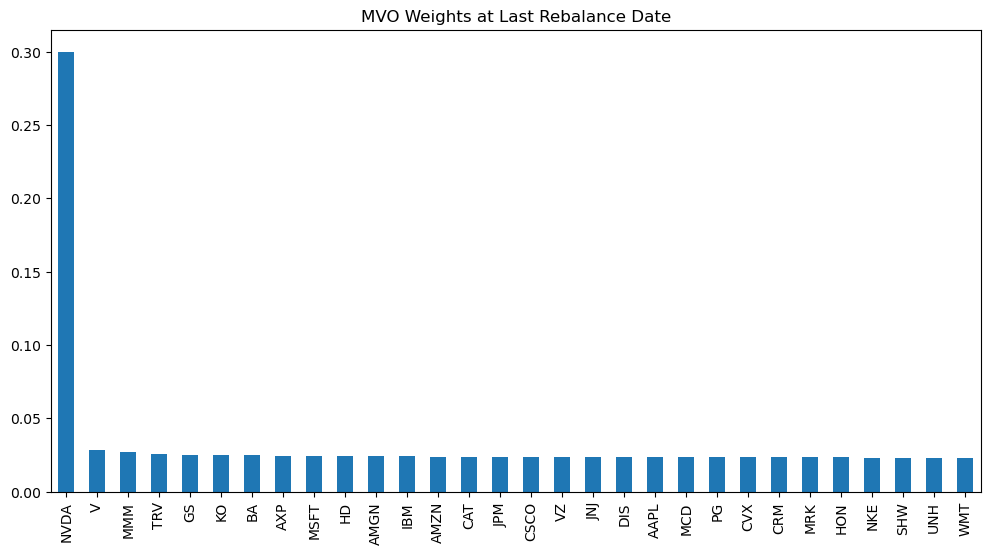

In [17]:
model_weights_df.iloc[-1].sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='MVO Weights at Last Rebalance Date')

### 2. Traditional mean-variance optimization

In [18]:
risk_free = 0.02  # Example risk-free rate
mvo_weights_df = mvo_quarterly_no_sec_cons(data, port_type, start_year=start_rebalance_year,
                                           trading_days_per_quarter=n_trading_days_per_quarter,
                                           min_train_periods=n_min_train_periods,
                                           risk_free_rate=risk_free)

mvo_weights_df = mvo_weights_df.round(4)
save_dataframe_to_new_sheet(mvo_weights_df, results_excel_path, 'MVO Weights')
# mvo_weights_df

Rebalance Dates: ['2016-01-04', '2016-04-01', '2016-07-01', '2016-10-03', '2017-01-03', '2017-04-03', '2017-07-03', '2017-10-02', '2018-01-02', '2018-04-02', '2018-07-02', '2018-10-01', '2019-01-02', '2019-04-01', '2019-07-01', '2019-10-01', '2020-01-02', '2020-04-01', '2020-07-01', '2020-10-01', '2021-01-04', '2021-04-01', '2021-07-01', '2021-10-01', '2022-01-03', '2022-04-01', '2022-07-01', '2022-10-03', '2023-01-03', '2023-04-03', '2023-07-03', '2023-10-02', '2024-01-02', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-02', '2025-04-01', '2025-07-01']

--- Rebalancing 1/39 ---
Rebalance Date: 2016-01-04
Training period: 2012-12-31 to 2015-12-31
Training days: 757

--- Rebalancing 2/39 ---
Rebalance Date: 2016-04-01
Training period: 2013-04-01 to 2016-03-31
Training days: 757

--- Rebalancing 3/39 ---
Rebalance Date: 2016-07-01
Training period: 2013-07-01 to 2016-06-30
Training days: 757

--- Rebalancing 4/39 ---
Rebalance Date: 2016-10-03
Training period: 2013-10-01 to 2016-09-30

<Axes: title={'center': 'MVO Weights at Last Rebalance Date'}>

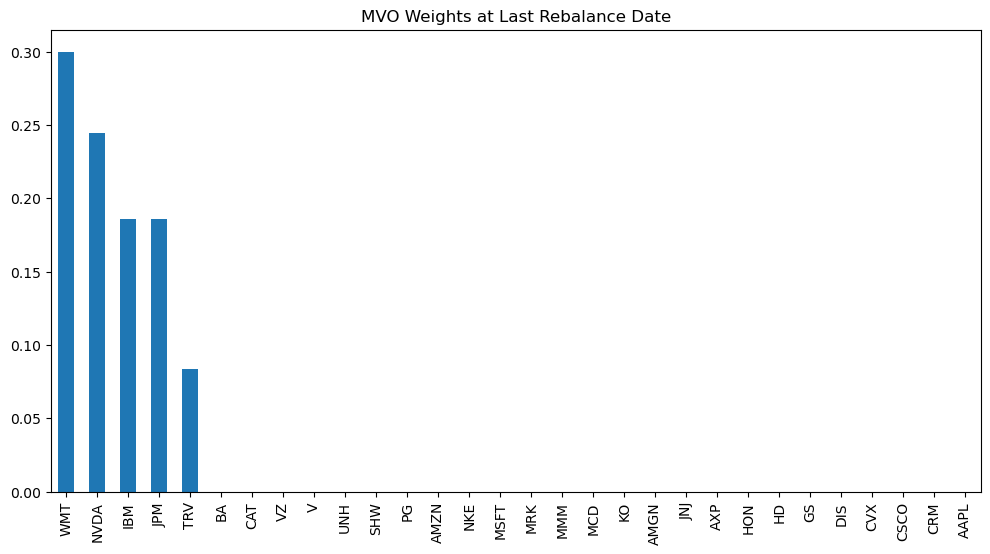

In [19]:
mvo_weights_df.iloc[-1].sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='MVO Weights at Last Rebalance Date')

In [20]:
# # --- Run the Check and Print Results ---
# violations_found = check_portfolio_constraints(
#     mvo_weights_df, 
#     asset_map, 
#     asset_lower_aggressive, 
#     asset_upper_aggressive
# )

# if not violations_found:
#     print("✅ All portfolio weights satisfy the constraints.")
# else:
#     print("❌ Constraint violations were found:")
#     for date, messages in violations_found.items():
#         print(f"\nOn {date}:")
#         for msg in messages:
#             print(f"  - {msg}")

# # check number of weights > 0 in each row
# non_zero_weights_count = (mvo_weights_df > 0).sum(axis=1)
# print("\nNumber of non-zero weights in each row:")
# print(non_zero_weights_count)

# # check total weight in each row to ensure it sums to 1
# total_weights = mvo_weights_df.sum(axis=1).round(2)
# print("\nTotal weights in each row (should be 1):")
# print(total_weights)

### 3. Equal weights

In [21]:
# Run equal weight portfolio
equal_weights_df = equal_weight_portfolio(data, rebalance_dates)
equal_weights_df = equal_weights_df.round(4)
save_dataframe_to_new_sheet(equal_weights_df, results_excel_path, 'Equal Weights')
# equal_weights_df

DataFrame saved to sheet 'Equal Weights' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/01_Results_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄


### 4. Benchmark

In [22]:
benchmark_list = ['DIA']
benchmark_data = getData(benchmark_list, startDate, endDate)
benchmark_data.fillna(method='ffill', inplace=True)

benchmark_df = pd.DataFrame(
   index=rebalance_dates,
    columns=benchmark_list,
   data=0.0
)
benchmark_df['DIA'] = 1.0

save_dataframe_to_new_sheet(benchmark_df, results_excel_path, 'Beanchmark Weights')
# benchmark_df

[*********************100%***********************]  1 of 1 completed

DataFrame saved to sheet 'Beanchmark Weights' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/01_Results_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄


### 4. Compared

In [23]:
# Main analysis
start_date = rebalance_dates[0]  # First rebalance date

# Calculate portfolio returns for each strategy
portfolios = {
    'Model Portfolio': model_weights_df,
    'MVO Portfolio': mvo_weights_df,
    'Equal Weight': equal_weights_df,
    'Benchmark': benchmark_df
}

portfolio_returns = {}
for name, weights in portfolios.items():
    returns = calculate_portfolio_returns(data, weights, rebalance_dates, start_date)
    portfolio_returns[name] = returns

benchmark_returns = calculate_portfolio_returns(benchmark_data, benchmark_df, rebalance_dates, start_date)
portfolio_returns['Benchmark'] = benchmark_returns

# Calculate performance metrics
performance_metrics = {}
benchmark_returns = portfolio_returns['Benchmark']

for name, returns in portfolio_returns.items():
    if name == 'Benchmark':
        metrics = calculate_performance_metrics(returns, returns)  # Self as benchmark
    else:
        metrics = calculate_performance_metrics(returns, benchmark_returns)
    performance_metrics[name] = metrics

# Create performance comparison DataFrame
performance_df = pd.DataFrame(performance_metrics).T
print("Portfolio Performance Comparison:")
print("=" * 50)
# performance_df.to_csv(f'{output_dir}/{train_type}/performance_comparison_run{run_no}.csv')
save_dataframe_to_new_sheet(performance_df.T, results_excel_path, 'Performance Comparison')
performance_df.round(4).T

Portfolio Performance Comparison:
DataFrame saved to sheet 'Performance Comparison' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/01_Results_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄


,Model Portfolio,MVO Portfolio,Equal Weight,Benchmark
Total Return (%),1279.7612,524.9993,385.3600,218.0028
Annualized Return (%),31.6680,21.1793,18.0095,12.8931
Volatility (%),24.0285,22.6877,17.6230,17.8164
Sharpe Ratio,1.1825,0.8726,0.9148,0.6581
Max Drawdown (%),-33.0827,-38.0530,-32.8136,-36.6956
Max Drawdown Duration (days),406.0000,538.0000,362.0000,477.0000
Sortino Ratio,1.5438,1.1235,1.0865,0.7740
Treynor Ratio,0.2604,0.2020,0.1653,0.1172
Jensen's Alpha (%),15.6223,8.3087,4.6869,-0.0049
Beta,1.0909,0.9798,0.9753,1.0004


In [24]:
# Plotting
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Cumulative Returns', 'Maximum Drawdown'),
    vertical_spacing=0.12,
    row_heights=[0.7, 0.3]
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot cumulative returns
for i, (name, returns) in enumerate(portfolio_returns.items()):
    #if name != 'Benchmark':
    cumulative_returns = (1 + returns).cumprod()
    fig.add_trace(
        go.Scatter(
            x=cumulative_returns.index,
            y=cumulative_returns.values,
            mode='lines',
            name=name,
            line=dict(color=colors[i], width=2),
            showlegend=True
        ),
        row=1, col=1
    )

# Plot drawdowns
for i, (name, returns) in enumerate(portfolio_returns.items()):
#if name != 'Benchmark':
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max * 100
    
    fig.add_trace(
        go.Scatter(
            x=drawdown.index,
            y=drawdown.values,
            mode='lines',
            name=name,
            line=dict(color=colors[i], width=2),
            showlegend=False
        ),
        row=2, col=1
    )

# Update layout
fig.update_layout(
    title='Portfolio Performance Comparison',
    height=800,
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Cumulative Return", row=1, col=1)
fig.update_yaxes(title_text="Drawdown (%)", row=2, col=1)

fig.show()

# Save the plot to a file
fig.write_html(f'{output_dir}/{train_type}/portfolio_performance_{model_type}_run_{run_no}.html')
# save image to file
fig.write_image(f'{output_dir}/{train_type}/portfolio_performance_{model_type}_run_{run_no}.png')

In [25]:
# Summary statistics
print("\nKey Performance Highlights:")
print("=" * 30)

best_return = performance_df['Annualized Return (%)'].idxmax()
print(f"Best Annualized Return: {best_return} ({performance_df.loc[best_return, 'Annualized Return (%)']:.2f}%)")

best_sharpe = performance_df['Sharpe Ratio'].idxmax()
print(f"Best Sharpe Ratio: {best_sharpe} ({performance_df.loc[best_sharpe, 'Sharpe Ratio']:.3f})")

best_sortino = performance_df['Sortino Ratio'].idxmax()
print(f"Best Sortino Ratio: {best_sortino} ({performance_df.loc[best_sortino, 'Sortino Ratio']:.3f})")

lowest_dd = performance_df['Max Drawdown (%)'].idxmax()  # Most negative (lowest)
print(f"Lowest Max Drawdown: {lowest_dd} ({performance_df.loc[lowest_dd, 'Max Drawdown (%)']:.2f}%)")

lowest_vol = performance_df['Volatility (%)'].idxmin()
print(f"Lowest Volatility: {lowest_vol} ({performance_df.loc[lowest_vol, 'Volatility (%)']:.2f}%)")


Key Performance Highlights:
Best Annualized Return: Model Portfolio (31.67%)
Best Sharpe Ratio: Model Portfolio (1.182)
Best Sortino Ratio: Model Portfolio (1.544)
Lowest Max Drawdown: Equal Weight (-32.81%)
Lowest Volatility: Equal Weight (17.62%)


In [26]:
# os.system('say "Model comparison has finished"')

# Quarterly Comparison

In [27]:
# Get quarterly periods
quarterly_periods = get_quarterly_periods(rebalance_dates, data)
quarterly_periods

# Portfolio definitions
portfolios = {
    'Model Portfolio': model_weights_df,
    'MVO Portfolio': mvo_weights_df,
    'Equal Weight': equal_weights_df,
    'Benchmark': benchmark_df
}

# Calculate quarterly performance for each portfolio
quarterly_results = {}
weights_df_2 = weights_df.copy
for portfolio_name, weights_df_2 in portfolios.items():
    quarterly_results[portfolio_name] = {}
    
    for period in quarterly_periods:
        quarter = period['quarter']
        returns = calculate_quarterly_portfolio_returns(data, weights_df_2, period)
        metrics = calculate_quarterly_metrics(returns)
        quarterly_results[portfolio_name][quarter] = metrics

# Create comprehensive results DataFrame
all_metrics = ['Total Return (%)', 'Annualized Return (%)',
               'Volatility (%)', 'Max Drawdown (%)', 
               'Max Drawdown Duration (days)', 'Sharpe Ratio', 'Sortino Ratio']
quarterly_comparison = {}

for metric in all_metrics:
    quarterly_comparison[metric] = pd.DataFrame({
        portfolio: {quarter: quarterly_results[portfolio][quarter][metric] 
                   for quarter in quarterly_results[portfolio]}
        for portfolio in portfolios.keys()
    })

# Display results
for metric in all_metrics:
    print(f"\n{metric}")
    print("-" * 40)
    print(quarterly_comparison[metric].round(4))
    # quarterly_comparison[metric].to_csv(f'{output_dir}/{train_type}/quarterly_{metric.lower().replace(" ", "_")}_run{run_no}.csv', index=True)



Total Return (%)
----------------------------------------
         Model Portfolio  MVO Portfolio  Equal Weight  Benchmark
Q1 2016           3.3071         2.8257        4.5968        0.0
Q2 2016          13.2685         4.5807        2.5565        0.0
Q3 2016          17.8532        14.9256        4.4933        0.0
Q4 2016          17.3841        19.7789        6.7478        0.0
Q1 2017           7.2007         6.3531        6.7976        0.0
Q2 2017          13.4473        16.5224        5.7005        0.0
Q3 2017          11.9653        11.3764        5.7643        0.0
Q4 2017          15.2683        12.8509       10.4227        0.0
Q1 2018           5.0595         9.0734       -0.5789        0.0
Q2 2018           6.0798        10.8932        6.0730        0.0
Q3 2018          14.6430        13.6654       10.9830        0.0
Q4 2018         -27.6157       -27.5485      -11.7947        0.0
Q1 2019          15.9897        12.1659       12.9984        0.0
Q2 2019           3.6174       

In [28]:
# --- เริ่มโค้ดสำหรับบันทึก Excel ---
qoq_excel_path = f"{output_dir}/{train_type}/02_Quarterly_{model_type}_{pe_type}_{pre_post}_run_{run_no}.xlsx"

for metric in all_metrics:
    sheet_name = metric.replace(" ", "_")
    df_to_save = quarterly_comparison[metric].round(4)
    save_dataframe_to_new_sheet(df_to_save, qoq_excel_path, sheet_name)


DataFrame saved to sheet 'Total_Return_(%)' in new file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/02_Quarterly_Transformer_tAPE_PostNorm_run_2_Return.xlsx ✨
DataFrame saved to sheet 'Annualized_Return_(%)' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/02_Quarterly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Volatility_(%)' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/02_Quarterly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Max_Drawdown_(%)' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/02_Quarterly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Max_Drawdown_Duration_(days)' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/02_Quarterly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Sharpe_Ratio' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1

In [29]:
# Plotting
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Quarterly Returns (%)', 'Quarterly Volatility (%)', 
                   'Quarterly Sharpe Ratio', 'Quarterly Max Drawdown (%)'),
    vertical_spacing=0.2,
    horizontal_spacing=0.2
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
quarters = list(quarterly_comparison['Total Return (%)'].index)

# Plot quarterly returns
for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=quarters,
            y=quarterly_comparison['Total Return (%)'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=True
        ),
        row=1, col=1
    )

for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=quarters,
            y=quarterly_comparison['Volatility (%)'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=False
        ),
        row=1, col=2
    )

for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=quarters,
            y=quarterly_comparison['Sharpe Ratio'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=False
        ),
        row=2, col=1
    )

for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=quarters,
            y=quarterly_comparison['Max Drawdown (%)'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=False
        ),
        row=2, col=2
    )

fig.update_layout(
    title='Quarterly Portfolio Performance Comparison',
    height=700,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update axes labels
fig.update_yaxes(title_text="Return (%)", row=1, col=1)
fig.update_yaxes(title_text="Volatility (%)", row=1, col=2)
fig.update_yaxes(title_text="Sharpe Ratio", row=2, col=1)
fig.update_yaxes(title_text="Max Drawdown (%)", row=2, col=2)

fig.show()

# Summary Statistics by Quarter
print("\n" + "="*60)
print("QUARTERLY PERFORMANCE SUMMARY")
print("="*60)

for quarter in quarters:
    print(f"\n{quarter}:")
    print("-" * 20)
    
    # Best performing portfolio this quarter
    quarter_returns = quarterly_comparison['Total Return (%)'].loc[quarter]
    best_return = quarter_returns.idxmax()
    print(f"Best Return: {best_return} ({quarter_returns[best_return]:.2f}%)")
    
    # Best Sharpe ratio this quarter
    quarter_sharpe = quarterly_comparison['Sharpe Ratio'].loc[quarter].dropna()
    if not quarter_sharpe.empty:
        best_sharpe = quarter_sharpe.idxmax()
        print(f"Best Sharpe: {best_sharpe} ({quarter_sharpe[best_sharpe]:.3f})")
    
    # Lowest volatility this quarter
    quarter_vol = quarterly_comparison['Volatility (%)'].loc[quarter].dropna()
    if not quarter_vol.empty:
        lowest_vol = quarter_vol.idxmin()
        print(f"Lowest Vol: {lowest_vol} ({quarter_vol[lowest_vol]:.2f}%)")

# Ranking Analysis
print("\n" + "="*60)
print("PORTFOLIO RANKINGS BY QUARTER")
print("="*60)

ranking_df = pd.DataFrame(index=quarters, columns=portfolios.keys())

for quarter in quarters:
    # Rank by quarterly returns (1 = best)
    quarter_returns = quarterly_comparison['Total Return (%)'].loc[quarter]
    ranks = quarter_returns.rank(ascending=False, method='min')
    ranking_df.loc[quarter] = ranks

print("\nRanking by Quarterly Returns (1=Best, 4=Worst):")
print(ranking_df.astype(int))

# Average ranking
avg_ranking = ranking_df.mean().sort_values()
print(f"\nAverage Ranking Across All Quarters:")
print("-" * 40)
for portfolio, avg_rank in avg_ranking.items():
    print(f"{portfolio}: {avg_rank:.2f}")

# Win rate analysis
print(f"\nQuarterly Win Rate (% of quarters ranked #1):")
print("-" * 45)
for portfolio in portfolios.keys():
    win_rate = (ranking_df[portfolio] == 1).sum() / len(quarters) * 100
    print(f"{portfolio}: {win_rate:.1f}%")

# Save the plot to a file
fig.write_html(f'{output_dir}/{train_type}/QoQ_performance_{model_type}_run_{run_no}.html')
fig.write_image(f'{output_dir}/{train_type}/QoQ_performance_{model_type}_run_{run_no}.png')


QUARTERLY PERFORMANCE SUMMARY

Q1 2016:
--------------------
Best Return: Equal Weight (4.60%)
Best Sharpe: Equal Weight (1.014)
Lowest Vol: Benchmark (0.00%)

Q2 2016:
--------------------
Best Return: Model Portfolio (13.27%)
Best Sharpe: Model Portfolio (2.878)
Lowest Vol: Benchmark (0.00%)

Q3 2016:
--------------------
Best Return: Model Portfolio (17.85%)
Best Sharpe: Model Portfolio (4.512)
Lowest Vol: Benchmark (0.00%)

Q4 2016:
--------------------
Best Return: MVO Portfolio (19.78%)
Best Sharpe: MVO Portfolio (3.027)
Lowest Vol: Benchmark (0.00%)

Q1 2017:
--------------------
Best Return: Model Portfolio (7.20%)
Best Sharpe: Equal Weight (4.067)
Lowest Vol: Benchmark (0.00%)

Q2 2017:
--------------------
Best Return: MVO Portfolio (16.52%)
Best Sharpe: MVO Portfolio (3.260)
Lowest Vol: Benchmark (0.00%)

Q3 2017:
--------------------
Best Return: Model Portfolio (11.97%)
Best Sharpe: Model Portfolio (3.209)
Lowest Vol: Benchmark (0.00%)

Q4 2017:
--------------------
Best 

### Yearly Comparison

In [30]:
# Main Analysis
print("Yearly Performance Analysis")
print("=" * 50)

# Get yearly periods
yearly_periods = get_yearly_periods(rebalance_dates, data)

# Portfolio definitions
portfolios = {
    'Model Portfolio': model_weights_df,
    'MVO Portfolio': mvo_weights_df,
    'Equal Weight': equal_weights_df,
    'Benchmark': benchmark_df
}

# Calculate yearly performance for each portfolio
yearly_results = {}
weights_df_2 = weights_df.copy()
for portfolio_name, weights_df_2 in portfolios.items():
    yearly_results[portfolio_name] = {}
    
    for period in yearly_periods:
        year = period['year']
        returns = calculate_yearly_portfolio_returns(data, weights_df_2, period, rebalance_dates)
        metrics = calculate_yearly_metrics(returns)
        yearly_results[portfolio_name][year] = metrics

# Create comprehensive results DataFrame
all_metrics = ['Total Return (%)', 'Annualized Return (%)', 'Volatility (%)', 
               'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown (%)', 
               'Max DD Duration (days)', 'VaR 95% (%)', 'Calmar Ratio', 'Trading Days']

yearly_comparison = {}

for metric in all_metrics:
    yearly_comparison[metric] = pd.DataFrame({
        portfolio: {year: yearly_results[portfolio][year][metric] 
                   for year in yearly_results[portfolio]}
        for portfolio in portfolios.keys()
    })

# Display results
for metric in all_metrics:
    print(f"\n{metric}")
    print("-" * 40)
    if metric in ['Trading Days']:
        print(yearly_comparison[metric].astype(int))
    else:
        print(yearly_comparison[metric].round(3))


Yearly Performance Analysis

Total Return (%)
----------------------------------------
      Model Portfolio  MVO Portfolio  Equal Weight  Benchmark
2016           63.392         49.164        20.588        0.0
2017           55.446         54.516        32.585        0.0
2018           -7.537         -0.708         1.868        0.0
2019           33.742         13.972        31.018        0.0
2020           35.710         34.260        19.787        0.0
2021           43.493         34.299        24.761        0.0
2022          -18.009        -32.507        -9.348        0.0
2023           38.287         28.603        22.863        0.0
2024           54.399         32.486        22.786        0.0
2025           26.377         17.094         9.431        0.0

Annualized Return (%)
----------------------------------------
      Model Portfolio  MVO Portfolio  Equal Weight  Benchmark
2016           63.712         49.402        20.678        0.0
2017           55.996         55.055       

In [31]:
# Plotting
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Annual Returns (%)', 'Annual Volatility (%)', 
                   'Annual Sharpe Ratio', 'Annual Max Drawdown (%)'),
                   #'Annual Sortino Ratio', 'Annual Calmar Ratio'),
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
years = list(yearly_comparison['Total Return (%)'].index)

# Plot annual returns
for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=years,
            y=yearly_comparison['Total Return (%)'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=True
        ),
        row=1, col=1
    )

# Plot annual volatility
for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=years,
            y=yearly_comparison['Volatility (%)'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=False
        ),
        row=1, col=2
    )

# Plot annual Sharpe ratio
for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=years,
            y=yearly_comparison['Sharpe Ratio'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=False
        ),
        row=2, col=1
    )

# Plot annual max drawdown
for i, portfolio in enumerate(portfolios.keys()):
    fig.add_trace(
        go.Bar(
            x=years,
            y=yearly_comparison['Max Drawdown (%)'][portfolio],
            name=portfolio,
            marker_color=colors[i],
            showlegend=False
        ),
        row=2, col=2
    )

# # Plot annual Sortino ratio
# for i, portfolio in enumerate(portfolios.keys()):
#     fig.add_trace(
#         go.Scatter(
#             x=years,
#             y=yearly_comparison['Sortino Ratio'][portfolio],
#             mode='lines+markers',
#             name=portfolio,
#             line=dict(color=colors[i]),
#             showlegend=False
#         ),
#         row=3, col=1
#     )

# # Plot annual Calmar ratio
# for i, portfolio in enumerate(portfolios.keys()):
#     fig.add_trace(
#         go.Scatter(
#             x=years,
#             y=yearly_comparison['Calmar Ratio'][portfolio],
#             mode='lines+markers',
#             name=portfolio,
#             line=dict(color=colors[i]),
#             showlegend=False
#         ),
#         row=3, col=2
#     )

# Update layout
fig.update_layout(
    title='Annual Portfolio Performance Comparison',
    height=900,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update axes labels
fig.update_yaxes(title_text="Return (%)", row=1, col=1)
fig.update_yaxes(title_text="Volatility (%)", row=1, col=2)
fig.update_yaxes(title_text="Sharpe Ratio", row=2, col=1)
fig.update_yaxes(title_text="Max Drawdown (%)", row=2, col=2)
# fig.update_yaxes(title_text="Sortino Ratio", row=3, col=1)
# fig.update_yaxes(title_text="Calmar Ratio", row=3, col=2)

fig.show()

# Save the plot to a file
fig.write_html(f'{output_dir}/{train_type}/YoY_performance_{model_type}_run_{run_no}.html')
fig.write_image(f'{output_dir}/{train_type}/YoY_performance_{model_type}_run_{run_no}.png')

In [32]:
# Summary Statistics by Year
print("\n" + "="*60)
print("ANNUAL PERFORMANCE SUMMARY")
print("="*60)

for year in years:
    print(f"\n{year}:")
    print("-" * 20)
    
    # Best performing portfolio this year
    year_returns = yearly_comparison['Total Return (%)'].loc[year]
    best_return = year_returns.idxmax()
    print(f"Best Return: {best_return} ({year_returns[best_return]:.2f}%)")
    
    # Best Sharpe ratio this year
    year_sharpe = yearly_comparison['Sharpe Ratio'].loc[year].dropna()
    if not year_sharpe.empty:
        best_sharpe = year_sharpe.idxmax()
        print(f"Best Sharpe: {best_sharpe} ({year_sharpe[best_sharpe]:.3f})")
    
    # Lowest volatility this year
    year_vol = yearly_comparison['Volatility (%)'].loc[year].dropna()
    if not year_vol.empty:
        lowest_vol = year_vol.idxmin()
        print(f"Lowest Vol: {lowest_vol} ({year_vol[lowest_vol]:.2f}%)")
    
    # Best Calmar ratio this year
    year_calmar = yearly_comparison['Calmar Ratio'].loc[year].dropna()
    if not year_calmar.empty:
        best_calmar = year_calmar.idxmax()
        print(f"Best Calmar: {best_calmar} ({year_calmar[best_calmar]:.3f})")

# Ranking Analysis
print("\n" + "="*60)
print("PORTFOLIO RANKINGS BY YEAR")
print("="*60)

ranking_df = pd.DataFrame(index=years, columns=portfolios.keys())

for year in years:
    # Rank by annual returns (1 = best)
    year_returns = yearly_comparison['Total Return (%)'].loc[year]
    ranks = year_returns.rank(ascending=False, method='min')
    ranking_df.loc[year] = ranks

print("\nRanking by Annual Returns (1=Best, 4=Worst):")
print(ranking_df.astype(int))

# Average ranking
avg_ranking = ranking_df.mean().sort_values()
print(f"\nAverage Ranking Across All Years:")
print("-" * 40)
for portfolio, avg_rank in avg_ranking.items():
    print(f"{portfolio}: {avg_rank:.2f}")

# Win rate analysis
print(f"\nAnnual Win Rate (% of years ranked #1):")
print("-" * 45)
for portfolio in portfolios.keys():
    win_rate = (ranking_df[portfolio] == 1).sum() / len(years) * 100
    print(f"{portfolio}: {win_rate:.1f}%")

# Multi-year consistency analysis
print(f"\nConsistency Analysis:")
print("-" * 25)
for portfolio in portfolios.keys():
    returns_series = yearly_comparison['Total Return (%)'][portfolio].dropna()
    if len(returns_series) > 1:
        consistency = returns_series.std()
        print(f"{portfolio} - Return Std Dev: {consistency:.2f}%")

# Best and worst years
print(f"\nBest and Worst Years:")
print("-" * 25)
for portfolio in portfolios.keys():
    returns_series = yearly_comparison['Total Return (%)'][portfolio].dropna()
    if len(returns_series) > 0:
        best_year = returns_series.idxmax()
        worst_year = returns_series.idxmin()
        print(f"{portfolio}:")
        print(f"  Best: {best_year} ({returns_series[best_year]:.2f}%)")
        print(f"  Worst: {worst_year} ({returns_series[worst_year]:.2f}%)")


ANNUAL PERFORMANCE SUMMARY

2016:
--------------------
Best Return: Model Portfolio (63.39%)
Best Sharpe: Model Portfolio (2.346)
Lowest Vol: Benchmark (0.00%)
Best Calmar: Model Portfolio (3.833)

2017:
--------------------
Best Return: Model Portfolio (55.45%)
Best Sharpe: Equal Weight (4.018)
Lowest Vol: Benchmark (0.00%)
Best Calmar: Equal Weight (12.163)

2018:
--------------------
Best Return: Equal Weight (1.87%)
Best Sharpe: Equal Weight (0.082)
Lowest Vol: Benchmark (0.00%)
Best Calmar: Equal Weight (0.105)

2019:
--------------------
Best Return: Model Portfolio (33.74%)
Best Sharpe: Equal Weight (2.084)
Lowest Vol: Benchmark (0.00%)
Best Calmar: Equal Weight (4.865)

2020:
--------------------
Best Return: Model Portfolio (35.71%)
Best Sharpe: Model Portfolio (0.958)
Lowest Vol: Benchmark (0.00%)
Best Calmar: Model Portfolio (1.163)

2021:
--------------------
Best Return: Model Portfolio (43.49%)
Best Sharpe: Equal Weight (1.779)
Lowest Vol: Benchmark (0.00%)
Best Calmar: 

In [33]:
# --- เริ่มโค้ดสำหรับบันทึก Excel ---
output_excel_path = f"{output_dir}/{train_type}/03_Yearly_{model_type}_{pe_type}_{pre_post}_run_{run_no}.xlsx"

for metric in all_metrics:
    sheet_name = metric.replace(" ", "_")
    df_to_save = yearly_comparison[metric].round(4)
    save_dataframe_to_new_sheet(df_to_save, output_excel_path, sheet_name)


DataFrame saved to sheet 'Total_Return_(%)' in new file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/03_Yearly_Transformer_tAPE_PostNorm_run_2_Return.xlsx ✨
DataFrame saved to sheet 'Annualized_Return_(%)' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/03_Yearly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Volatility_(%)' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/03_Yearly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Sharpe_Ratio' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/03_Yearly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Sortino_Ratio' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/03_Yearly_Transformer_tAPE_PostNorm_run_2_Return.xlsx 📄
DataFrame saved to sheet 'Max_Drawdown_(%)' in existing file: Results_NoCons/01_2_Transformer_tAPE_PostNorm_temp_1.0/03_Yearly_Transformer_tAPE_

In [34]:
yearly_comparison['Sortino Ratio']

,Model Portfolio,MVO Portfolio,Equal Weight,Benchmark
2016,3.342936,3.175379,1.752613,NaN
2017,4.216369,4.453272,5.330776,NaN
2018,-0.293737,0.053724,0.100089,NaN
2019,2.613295,1.149468,2.618923,NaN
2020,1.118890,1.128581,0.727299,NaN
2021,2.600730,2.760591,2.508893,NaN
2022,-1.000822,-1.920343,-0.712017,NaN
2023,3.681630,2.762736,2.714408,NaN
2024,3.170193,2.252535,2.671141,NaN
2025,1.885254,1.886438,1.068268,NaN


In [35]:
os.system('say "All code has finished"')

0